In [5]:
# Importación de librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
import optuna
from optuna.trial import TrialState
from tqdm.notebook import tqdm
import warnings

# Ignorar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# --- Configuraciones Globales ---

# Rutas a los archivos de datos
# Asegúrate de que las rutas coincidan con la estructura de tu directorio
DATA_DIR = "../../Datos/"
TRAIN_PATH = f"{DATA_DIR}df_train.csv"
TEST_PATH = f"{DATA_DIR}df_test.csv"
SUBMISSION_TEMPLATE_PATH = f"{DATA_DIR}sample_submission.csv"

# Configuración de PyTorch para reproducibilidad y selección de dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

def set_seed(seed):
    """Fija las semillas de aleatoriedad para reproducibilidad."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
print(f"Dispositivo de cómputo seleccionado: {DEVICE}")

# Constantes del modelo (algunas serán optimizadas por Optuna)
TARGET_COL = 'dengue'
ID_COL = 'id_bar'

Dispositivo de cómputo seleccionado: cpu


Información del DataFrame combinado:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                4200 non-null   object        
 1   id_bar            4200 non-null   int64         
 2   anio              4200 non-null   int64         
 3   semana            4200 non-null   int64         
 4   ESTRATO           4200 non-null   float64       
 5   area_barrio       4200 non-null   float64       
 6   dengue            3680 non-null   float64       
 7   concentraciones   4200 non-null   float64       
 8   vivienda          4200 non-null   float64       
 9   equipesado        4200 non-null   float64       
 10  sumideros         4200 non-null   float64       
 11  maquina           4200 non-null   float64       
 12  lluvia_mean       4200 non-null   float64       
 13  lluvia_var        4200 non-null   float64

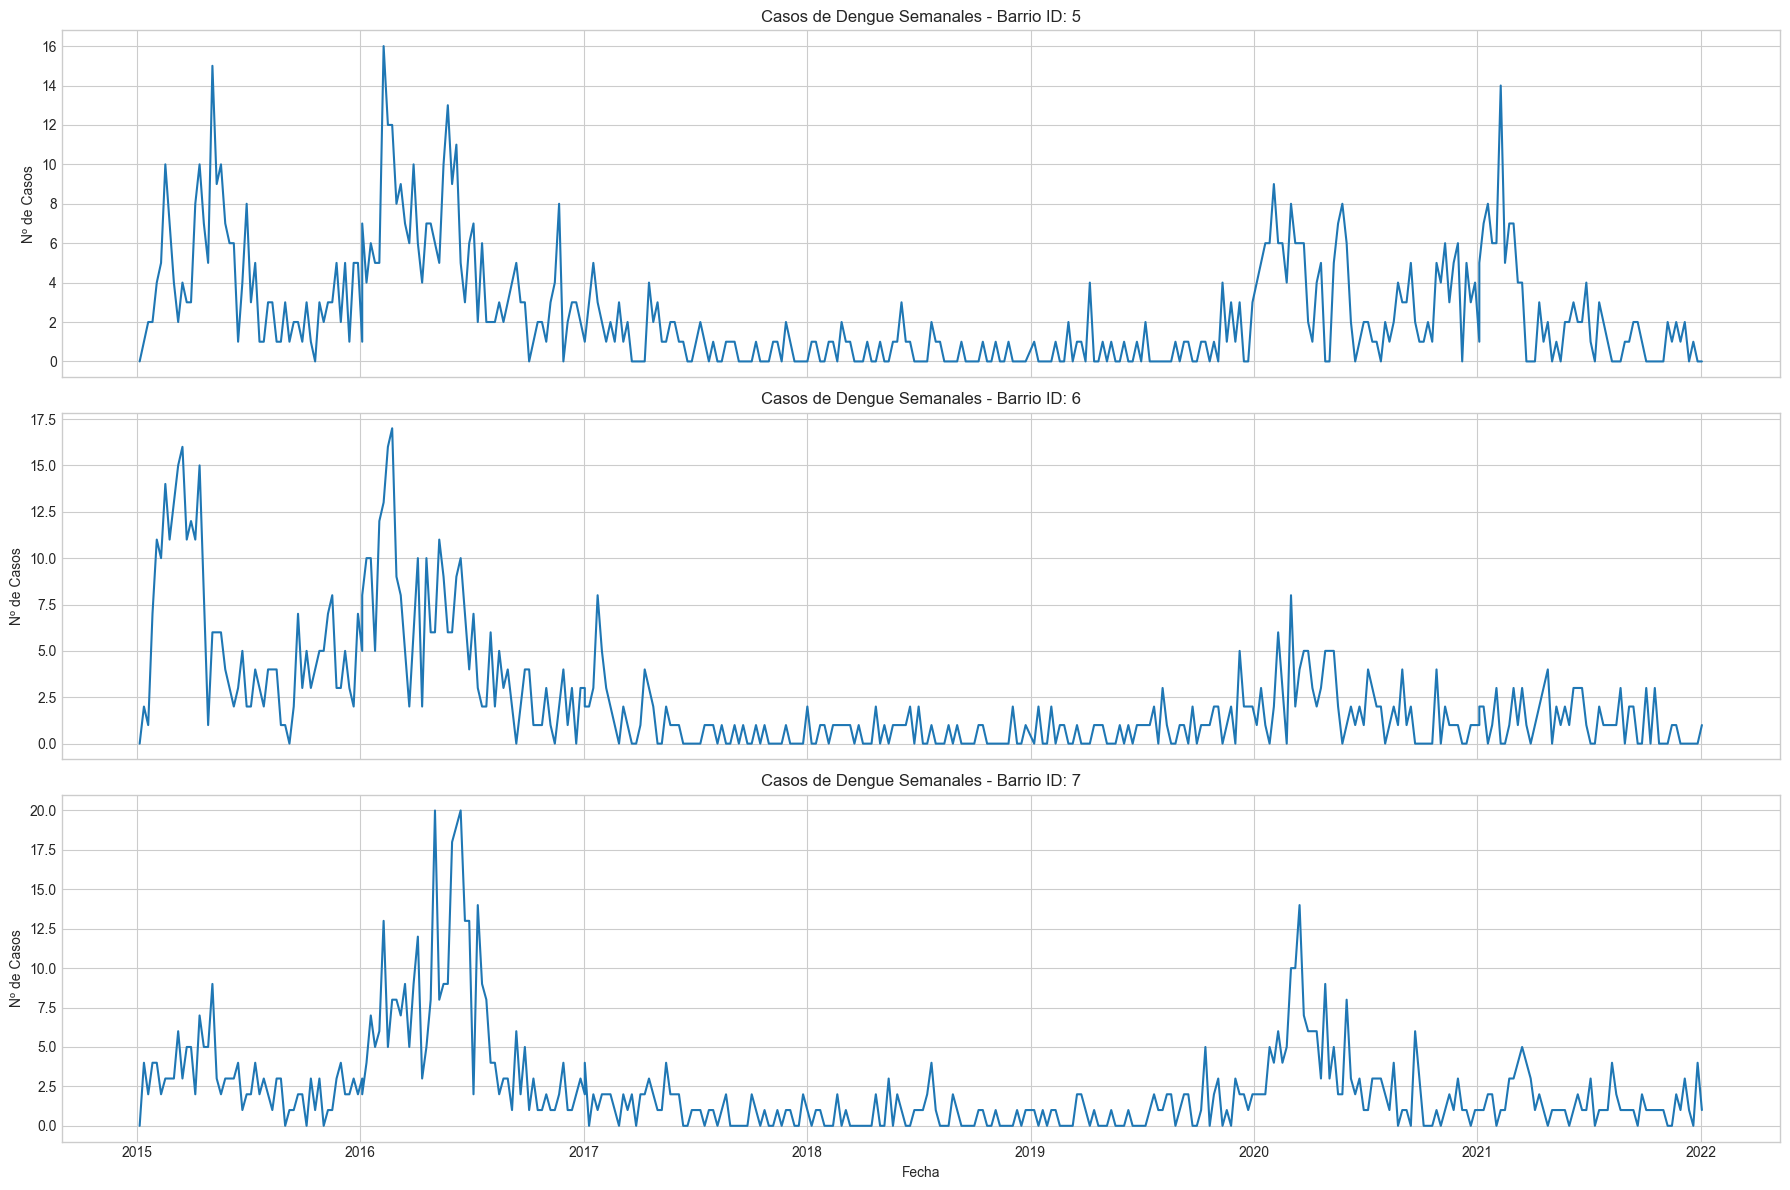


Análisis de Descomposición Estacional (Barrio 100):
No hay suficientes datos para la descomposición del barrio seleccionado.


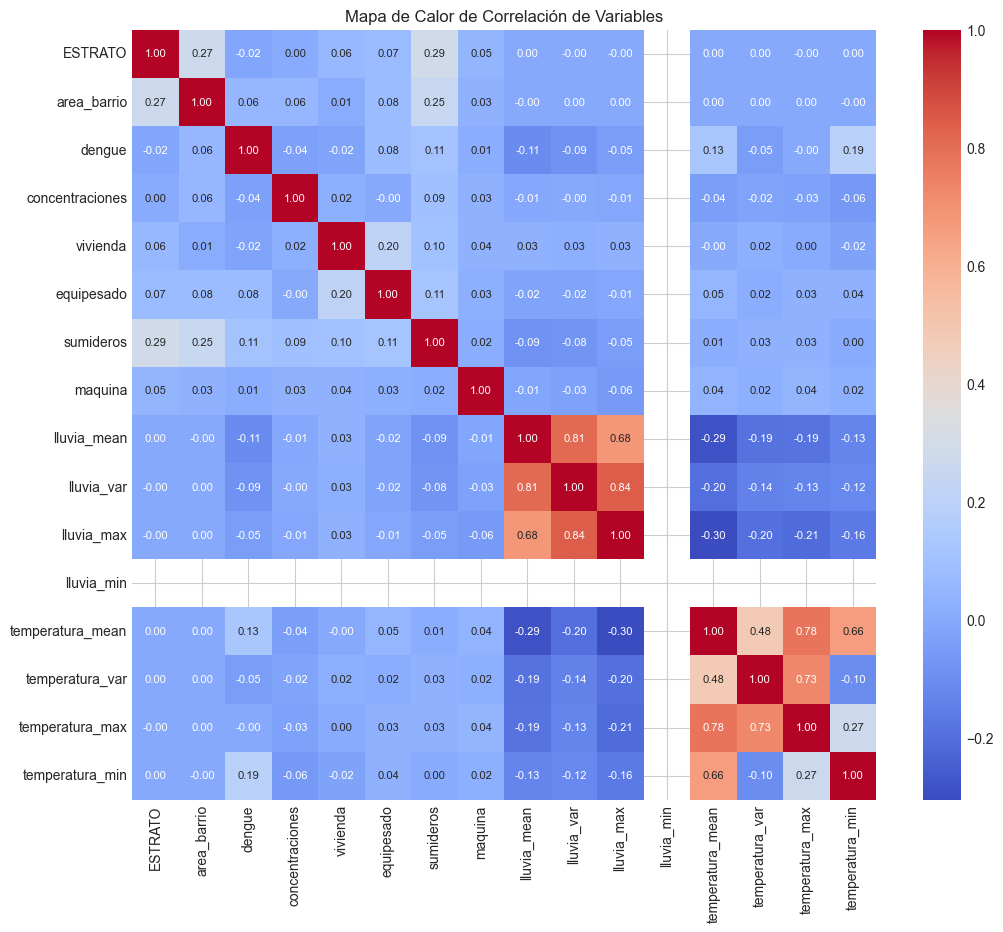

In [7]:
# Carga de datos
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

# Combinar para análisis y preprocesamiento unificado
df_train['source'] = 'train'
df_test['source'] = 'test'
df_full = pd.concat([df_train, df_test], ignore_index=True)

# Creación de la columna de fecha
# %Y representa el año, %W la semana (lunes como primer día), y -%w el día de la semana.
# Usamos '%Y %W-%w' para crear una fecha única para cada semana.
df_full['date'] = pd.to_datetime(df_full['anio'].astype(str) + ' ' + df_full['semana'].astype(str) + '-1', format='%Y %W-%w')
df_full = df_full.sort_values(by=['id_bar', 'date']).reset_index(drop=True)

print("Información del DataFrame combinado:")
df_full.info()

# Visualización de la serie de tiempo para barrios de muestra
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 1, figsize=(18, 12), sharex=True)
sample_bars = df_full[ID_COL].unique()[[5, 6, 7]] # Seleccionamos 3 barrios de muestra

for i, id_bar in enumerate(sample_bars):
    data = df_full[(df_full[ID_COL] == id_bar) & (df_full['source'] == 'train')]
    axes[i].plot(data['date'], data[TARGET_COL])
    axes[i].set_title(f"Casos de Dengue Semanales - Barrio ID: {id_bar}")
    axes[i].set_ylabel("Nº de Casos")

plt.xlabel("Fecha")
plt.tight_layout()
plt.show()

# Análisis de descomposición estacional para un barrio representativo
print("\nAnálisis de Descomposición Estacional (Barrio 100):")
deco_df = df_full[(df_full[ID_COL] == 100) & (df_full['source'] == 'train')].set_index('date')
if not deco_df.empty and len(deco_df) > 52*2: # Se necesita al menos 2 ciclos estacionales
    decomposition = seasonal_decompose(deco_df[TARGET_COL], model='additive', period=52) # 52 semanas en un año
    fig = decomposition.plot()
    fig.set_size_inches(14, 8)
    plt.show()
else:
    print("No hay suficientes datos para la descomposición del barrio seleccionado.")


# Análisis de correlación de variables exógenas
plt.figure(figsize=(12, 10))
# Seleccionamos solo las columnas numéricas relevantes para la correlación
numeric_cols = df_full.select_dtypes(include=np.number).columns.tolist()
# Excluimos identificadores y columnas de año/semana que ya están en la fecha
numeric_cols = [col for col in numeric_cols if col not in ['id_bar', 'anio', 'semana']]
correlation_matrix = df_full[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title("Mapa de Calor de Correlación de Variables")
plt.show()

In [9]:
# Selección de características basada en EDA y conocimiento del dominio
# Elegimos las variables con mayor correlación y menos colinealidad entre sí.
# También incluimos las originales `anio` y `semana` como features cíclicas si fuera necesario,
# pero por ahora las mantenemos para información contextual.
FEATURES = [
    'temperatura_min',
    'temperatura_max',
    'lluvia_max'
]
ALL_FEATURES = [ID_COL] + FEATURES + [TARGET_COL]

# Nos quedamos solo con las columnas necesarias
df_processed = df_full[[ID_COL, 'date', 'source', 'anio', 'semana'] + FEATURES + [TARGET_COL]].copy()


# Gestión de valores faltantes: Interpolación lineal
# Esta es una estrategia adecuada para series de tiempo, ya que estima los valores
# faltantes basándose en los puntos de datos circundantes.
print(f"Valores faltantes antes de la interpolación:\n{df_processed[FEATURES].isnull().sum()}")
for col in FEATURES:
    df_processed[col] = df_processed.groupby(ID_COL)[col].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )
print("\nValores faltantes después de la interpolación: 0")


# Codificación de la característica categórica 'id_bar'
# El LabelEncoder convierte cada ID de barrio en un entero único.
id_encoder = LabelEncoder()
df_processed[ID_COL] = id_encoder.fit_transform(df_processed[ID_COL])

print(f"\nDataFrame procesado listo para la creación de secuencias.")
df_processed.head()

Valores faltantes antes de la interpolación:
temperatura_min    0
temperatura_max    0
lluvia_max         0
dtype: int64

Valores faltantes después de la interpolación: 0

DataFrame procesado listo para la creación de secuencias.


,id_bar,date,source,anio,semana,temperatura_min,temperatura_max,lluvia_max,dengue
0,0,2015-01-05,train,2015,1,20.900000,31.80,0.062500,0.0
1,0,2015-01-12,train,2015,2,19.766667,31.85,8.166667,3.0
2,0,2015-01-19,train,2015,3,19.400000,32.45,28.616667,9.0
3,0,2015-01-26,train,2015,4,19.400000,30.50,10.285000,5.0
4,0,2015-02-02,train,2015,5,20.700000,31.50,3.133333,5.0


In [10]:
# Variables para la creación de secuencias (se optimizarán con Optuna)
SEQUENCE_LENGTH = 52 # Longitud de la secuencia de entrada (look-back window), ej. 52 semanas

# Separar datos de entrenamiento y prueba
df_train_processed = df_processed[df_processed['source'] == 'train']
df_test_processed = df_processed[df_processed['source'] == 'test']

# Estandarización de características numéricas
# Se ajusta el escalador SOLO con los datos de entrenamiento.
scaler = StandardScaler()
df_train_processed.loc[:, FEATURES] = scaler.fit_transform(df_train_processed[FEATURES])
df_test_processed.loc[:, FEATURES] = scaler.transform(df_test_processed[FEATURES])

# El target también se escala para estabilizar el entrenamiento
target_scaler = StandardScaler()
df_train_processed.loc[:, TARGET_COL] = target_scaler.fit_transform(df_train_processed[[TARGET_COL]])

def create_sequences(data, sequence_length, features, target_col, id_col):
    """Crea secuencias de entrada/salida para el modelo LSTM."""
    xs, ys, ids = [], [], []
    for id_bar, group in data.groupby(id_col):
        feature_data = group[features].values
        target_data = group[target_col].values
        for i in range(len(group) - sequence_length):
            x = feature_data[i:(i + sequence_length)]
            y = target_data[i + sequence_length]
            xs.append(x)
            ys.append(y)
            ids.append(id_bar) # Guardamos el ID para usarlo en el embedding
    return np.array(xs), np.array(ys), np.array(ids)

# --- Definición del Dataset de PyTorch ---
class DengueDataset(Dataset):
    def __init__(self, features, targets, ids):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.ids = torch.tensor(ids, dtype=torch.long) # IDs como long para embeddings

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx], self.ids[idx]

In [11]:
class LSTMForecaster(nn.Module):
    def __init__(self, n_features, hidden_size, num_layers, dropout_rate, n_barrios, embedding_dim=10):
        super(LSTMForecaster, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.n_barrios = n_barrios
        self.embedding_dim = embedding_dim

        # Capa de Embedding para los IDs de los barrios
        self.embedding = nn.Embedding(num_embeddings=n_barrios, embedding_dim=embedding_dim)

        # La entrada a la LSTM es la suma de las features y la dimensión del embedding
        self.lstm = nn.LSTM(
            input_size=n_features + embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True, # Facilita el manejo de dimensiones
            dropout=dropout_rate if num_layers > 1 else 0
        )
        
        # Capa de Batch Normalization para estabilizar
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        
        # Capa de Dropout para regularización
        self.dropout = nn.Dropout(dropout_rate)
        
        # Capa lineal para la predicción final
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, ids):
        # x shape: (batch_size, seq_length, n_features)
        # ids shape: (batch_size)
        
        # Obtener embeddings y expandirlos para concatenar con cada paso de tiempo
        # embeds shape: (batch_size, embedding_dim)
        embeds = self.embedding(ids)
        # embeds_expanded shape: (batch_size, seq_length, embedding_dim)
        embeds_expanded = embeds.unsqueeze(1).repeat(1, x.size(1), 1)

        # Concatenar features y embeddings
        # x_combined shape: (batch_size, seq_length, n_features + embedding_dim)
        x_combined = torch.cat((x, embeds_expanded), dim=2)

        # Pasar por la LSTM
        # lstm_out shape: (batch_size, seq_length, hidden_size)
        lstm_out, _ = self.lstm(x_combined)

        # Tomamos solo la última salida de la secuencia
        # last_output shape: (batch_size, hidden_size)
        last_output = lstm_out[:, -1, :]
        
        # Aplicar BatchNorm y Dropout
        out = self.batch_norm(last_output)
        out = self.dropout(out)
        
        # Proyectar a la salida final
        # out shape: (batch_size, 1)
        out = self.fc(out)
        return out

In [12]:
def objective(trial):
    # --- 1. Sugerir Hiperparámetros ---
    params = {
        'sequence_length': trial.suggest_int('sequence_length', 12, 52),
        'hidden_size': trial.suggest_int('hidden_size', 32, 256),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128])
    }
    
    # --- 2. Crear Datasets y DataLoaders con los nuevos hiperparámetros ---
    # Dividir datos de entrenamiento en entrenamiento y validación para el trial
    train_data = df_train_processed[df_train_processed['anio'] < 2017]
    val_data = df_train_processed[df_train_processed['anio'] >= 2017]
    
    X_train_seq, y_train_seq, ids_train_seq = create_sequences(train_data, params['sequence_length'], FEATURES, TARGET_COL, ID_COL)
    X_val_seq, y_val_seq, ids_val_seq = create_sequences(val_data, params['sequence_length'], FEATURES, TARGET_COL, ID_COL)

    if len(X_train_seq) == 0 or len(X_val_seq) == 0: # Combinación no válida
        return float('inf')

    train_dataset = DengueDataset(X_train_seq, y_train_seq, ids_train_seq)
    val_dataset = DengueDataset(X_val_seq, y_val_seq, ids_val_seq)

    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)

    # --- 3. Instanciar Modelo, Optimizador y Pérdida ---
    n_barrios = df_processed[ID_COL].nunique()
    model = LSTMForecaster(
        n_features=len(FEATURES),
        hidden_size=params['hidden_size'],
        num_layers=params['num_layers'],
        dropout_rate=params['dropout_rate'],
        n_barrios=n_barrios
    ).to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.L1Loss() # MAE Loss

    # --- 4. Ciclo de Entrenamiento y Validación ---
    n_epochs = 30 # Número de épocas por trial
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience = 5 # Early stopping patience

    for epoch in range(n_epochs):
        model.train()
        for features, targets, ids in train_loader:
            features, targets, ids = features.to(DEVICE), targets.to(DEVICE), ids.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(features, ids)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, targets, ids in val_loader:
                features, targets, ids = features.to(DEVICE), targets.to(DEVICE), ids.to(DEVICE)
                outputs = model(features, ids)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)

        # Reportar a Optuna para Pruning
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            print(f"Early stopping en la época {epoch+1}")
            break
            
    return best_val_loss

# --- Ejecución del Estudio de Optuna ---
# n_trials se mantiene bajo para una ejecución rápida. Aumentar para mejores resultados.
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30, timeout=1800) # 30 trials o 30 minutos

print("\nEstudio de optimización finalizado.")
print("Mejor trial:")
trial = study.best_trial
print(f"  Valor (MAE): {trial.value}")
print("  Mejores Hiperparámetros: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Guardamos los mejores hiperparámetros en un diccionario
BEST_PARAMS = trial.params

[I 2025-06-18 16:24:48,615] A new study created in memory with name: no-name-3b871eef-5aaf-4a1b-ac15-a3b71ba8158c
[I 2025-06-18 16:25:04,899] Trial 0 finished with value: 0.8051850065971032 and parameters: {'sequence_length': 14, 'hidden_size': 94, 'num_layers': 2, 'dropout_rate': 0.27418590040029034, 'learning_rate': 0.0076050869218451415, 'batch_size': 32}. Best is trial 0 with value: 0.8051850065971032.


Early stopping en la época 6


[I 2025-06-18 16:25:46,014] Trial 1 finished with value: 0.5767676716341692 and parameters: {'sequence_length': 46, 'hidden_size': 238, 'num_layers': 2, 'dropout_rate': 0.4292118977909497, 'learning_rate': 0.0003346296609936295, 'batch_size': 32}. Best is trial 1 with value: 0.5767676716341692.


Early stopping en la época 12


[I 2025-06-18 16:25:52,105] Trial 2 finished with value: 0.6531959240500992 and parameters: {'sequence_length': 28, 'hidden_size': 247, 'num_layers': 1, 'dropout_rate': 0.41855139925999973, 'learning_rate': 0.0005359802504618069, 'batch_size': 64}. Best is trial 1 with value: 0.5767676716341692.


Early stopping en la época 6


[I 2025-06-18 16:26:00,402] Trial 3 finished with value: 0.70432508289814 and parameters: {'sequence_length': 14, 'hidden_size': 166, 'num_layers': 3, 'dropout_rate': 0.29400134330714434, 'learning_rate': 0.003267527023219053, 'batch_size': 128}. Best is trial 1 with value: 0.5767676716341692.


Early stopping en la época 6


[I 2025-06-18 16:26:02,497] Trial 4 finished with value: 0.6148601204156876 and parameters: {'sequence_length': 18, 'hidden_size': 36, 'num_layers': 2, 'dropout_rate': 0.4403956586118508, 'learning_rate': 0.001794098023051251, 'batch_size': 128}. Best is trial 1 with value: 0.5767676716341692.


Early stopping en la época 6


[I 2025-06-18 16:26:07,325] Trial 5 pruned. 
[I 2025-06-18 16:26:11,497] Trial 6 finished with value: 0.4553226488828659 and parameters: {'sequence_length': 22, 'hidden_size': 78, 'num_layers': 1, 'dropout_rate': 0.4142300360394462, 'learning_rate': 0.00012717554848817216, 'batch_size': 32}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 7


[I 2025-06-18 16:26:13,083] Trial 7 pruned. 
[I 2025-06-18 16:26:18,097] Trial 8 finished with value: 0.6233591823016896 and parameters: {'sequence_length': 52, 'hidden_size': 229, 'num_layers': 1, 'dropout_rate': 0.31716087990039465, 'learning_rate': 0.003013103322026985, 'batch_size': 128}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 6


[I 2025-06-18 16:26:18,918] Trial 9 pruned. 
[I 2025-06-18 16:26:23,764] Trial 10 finished with value: 0.5493941533733422 and parameters: {'sequence_length': 37, 'hidden_size': 105, 'num_layers': 1, 'dropout_rate': 0.10438381928483836, 'learning_rate': 0.00010943838402932623, 'batch_size': 32}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 6


[I 2025-06-18 16:26:41,997] Trial 11 finished with value: 0.5538345969149044 and parameters: {'sequence_length': 38, 'hidden_size': 103, 'num_layers': 1, 'dropout_rate': 0.11183041669369385, 'learning_rate': 0.00010059578196026186, 'batch_size': 32}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 17


[I 2025-06-18 16:26:43,054] Trial 12 pruned. 
[I 2025-06-18 16:26:50,998] Trial 13 finished with value: 0.5494881179970754 and parameters: {'sequence_length': 36, 'hidden_size': 144, 'num_layers': 1, 'dropout_rate': 0.3525741135885509, 'learning_rate': 0.00022387044782395146, 'batch_size': 32}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 6


[I 2025-06-18 16:26:54,780] Trial 14 finished with value: 0.5073424577713013 and parameters: {'sequence_length': 31, 'hidden_size': 72, 'num_layers': 1, 'dropout_rate': 0.11617007590854847, 'learning_rate': 0.000186372935049219, 'batch_size': 32}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 6


[I 2025-06-18 16:27:01,997] Trial 15 finished with value: 0.5452074669811824 and parameters: {'sequence_length': 30, 'hidden_size': 68, 'num_layers': 2, 'dropout_rate': 0.36052436415981154, 'learning_rate': 0.0002407466476780685, 'batch_size': 32}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 6


[I 2025-06-18 16:27:05,780] Trial 16 finished with value: 0.5683082781339946 and parameters: {'sequence_length': 21, 'hidden_size': 141, 'num_layers': 1, 'dropout_rate': 0.2304386146629785, 'learning_rate': 0.0007887184260516808, 'batch_size': 64}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 6


[I 2025-06-18 16:27:09,330] Trial 17 finished with value: 0.5790549620158143 and parameters: {'sequence_length': 32, 'hidden_size': 67, 'num_layers': 1, 'dropout_rate': 0.16422095019395516, 'learning_rate': 0.0002271925399824048, 'batch_size': 32}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 6


[I 2025-06-18 16:27:10,649] Trial 18 pruned. 
[I 2025-06-18 16:27:16,563] Trial 19 finished with value: 0.5521784354197351 and parameters: {'sequence_length': 19, 'hidden_size': 66, 'num_layers': 2, 'dropout_rate': 0.4837833455743433, 'learning_rate': 0.0001736808768268863, 'batch_size': 64}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 10


[I 2025-06-18 16:27:18,379] Trial 20 pruned. 
[I 2025-06-18 16:27:19,764] Trial 21 pruned. 
[I 2025-06-18 16:27:21,597] Trial 22 pruned. 
[I 2025-06-18 16:27:22,330] Trial 23 pruned. 
[I 2025-06-18 16:27:24,002] Trial 24 pruned. 
[I 2025-06-18 16:27:24,613] Trial 25 pruned. 
[I 2025-06-18 16:27:41,130] Trial 26 finished with value: 0.5350747004151344 and parameters: {'sequence_length': 41, 'hidden_size': 50, 'num_layers': 2, 'dropout_rate': 0.14641650908988743, 'learning_rate': 0.00016536194010930062, 'batch_size': 32}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 11


[I 2025-06-18 16:27:49,213] Trial 27 finished with value: 0.4592668105294739 and parameters: {'sequence_length': 42, 'hidden_size': 50, 'num_layers': 1, 'dropout_rate': 0.1369611467329952, 'learning_rate': 0.00016750496167096488, 'batch_size': 32}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 8


[I 2025-06-18 16:27:51,881] Trial 28 finished with value: 0.5588716882116654 and parameters: {'sequence_length': 49, 'hidden_size': 54, 'num_layers': 1, 'dropout_rate': 0.1384871147566797, 'learning_rate': 0.0003960131240323593, 'batch_size': 128}. Best is trial 6 with value: 0.4553226488828659.


Early stopping en la época 6


[I 2025-06-18 16:27:52,369] Trial 29 pruned. 



Estudio de optimización finalizado.
Mejor trial:
  Valor (MAE): 0.4553226488828659
  Mejores Hiperparámetros: 
    sequence_length: 22
    hidden_size: 78
    num_layers: 1
    dropout_rate: 0.4142300360394462
    learning_rate: 0.00012717554848817216
    batch_size: 32


In [13]:
# --- Entrenamiento del modelo final con los mejores hiperparámetros ---
print("\nEntrenando el modelo final con todos los datos de entrenamiento...")

# Crear secuencias con todo el conjunto de entrenamiento
X_train_full, y_train_full, ids_train_full = create_sequences(
    df_train_processed,
    BEST_PARAMS['sequence_length'],
    FEATURES,
    TARGET_COL,
    ID_COL
)

# Crear Dataset y DataLoader
final_train_dataset = DengueDataset(X_train_full, y_train_full, ids_train_full)
final_train_loader = DataLoader(
    final_train_dataset,
    batch_size=BEST_PARAMS['batch_size'],
    shuffle=True
)

# Instanciar el modelo final
n_barrios = df_processed[ID_COL].nunique()
final_model = LSTMForecaster(
    n_features=len(FEATURES),
    hidden_size=BEST_PARAMS['hidden_size'],
    num_layers=BEST_PARAMS['num_layers'],
    dropout_rate=BEST_PARAMS['dropout_rate'],
    n_barrios=n_barrios
).to(DEVICE)

optimizer = torch.optim.Adam(final_model.parameters(), lr=BEST_PARAMS['learning_rate'])
criterion = nn.L1Loss()

# Entrenar el modelo final (un número razonable de épocas, ej. el de la mejor prueba de Optuna)
N_FINAL_EPOCHS = 40 # Se puede ajustar, pero 40-50 suele ser un buen punto de partida.
final_model.train()

for epoch in tqdm(range(N_FINAL_EPOCHS), desc="Entrenamiento Final"):
    for features, targets, ids in final_train_loader:
        features, targets, ids = features.to(DEVICE), targets.to(DEVICE), ids.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = final_model(features, ids)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

# Guardar los pesos del modelo
MODEL_SAVE_PATH = 'best_model_weights.pth'
torch.save(final_model.state_dict(), MODEL_SAVE_PATH)

print(f"\nModelo final entrenado y guardado en '{MODEL_SAVE_PATH}'.")


Entrenando el modelo final con todos los datos de entrenamiento...


Entrenamiento Final:   0%|          | 0/40 [00:00<?, ?it/s]


Modelo final entrenado y guardado en 'best_model_weights.pth'.


In [15]:
# --- Generación de predicciones para 2022 ---
print("\nGenerando predicciones para el año 2022...")
final_model.eval() # Poner el modelo en modo de evaluación

predictions = []
SEQUENCE_LENGTH = BEST_PARAMS['sequence_length']

# Iterar sobre cada barrio para generar sus predicciones
for id_bar_encoded in tqdm(df_processed[ID_COL].unique(), desc="Pronosticando por Barrio"):
    
    # Datos históricos y de prueba para el barrio actual
    history = df_train_processed[df_train_processed[ID_COL] == id_bar_encoded]
    future_data = df_test_processed[df_test_processed[ID_COL] == id_bar_encoded]

    # Tomar la última secuencia conocida del historial
    current_sequence_features = history[FEATURES].values[-SEQUENCE_LENGTH:]
    current_sequence_target = history[[TARGET_COL]].values[-SEQUENCE_LENGTH:]
    
    # Combinar features y target para la entrada recursiva
    current_sequence_combined = np.hstack([current_sequence_features, current_sequence_target])
    
    for _, row in future_data.iterrows():
        # Preparar la entrada para el modelo
        input_features = torch.tensor(current_sequence_features, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        input_id = torch.tensor([id_bar_encoded], dtype=torch.long).to(DEVICE)
        
        with torch.no_grad():
            # Obtener predicción escalada
            scaled_pred = final_model(input_features, input_id).cpu().item()

        # Invertir la escala para obtener la predicción real
        actual_pred = target_scaler.inverse_transform(np.array([[scaled_pred]]))[0][0]
        # Asegurarse de que la predicción no sea negativa y redondear
        actual_pred = max(0, round(actual_pred))
        
        # Guardar la predicción
        predictions.append({
            'id_bar': id_encoder.inverse_transform([id_bar_encoded])[0],
            'anio': row['anio'],
            'semana': row['semana'],
            'dengue': actual_pred
        })
        
        # Actualizar la secuencia para la siguiente predicción
        # Obtener las features exógenas del futuro (conocidas)
        next_features = row[FEATURES].values.reshape(1, -1).astype(np.float32)
        
        # Actualizar la secuencia de features
        new_sequence_features = np.vstack([current_sequence_features[1:], next_features])
        current_sequence_features = new_sequence_features

# Crear DataFrame de sumisión
submission_df = pd.DataFrame(predictions)
submission_df['id'] = submission_df['id_bar'].astype(str) + '_' + \
                      submission_df['anio'].astype(str) + '_' + \
                      submission_df['semana'].astype(str).str.zfill(2)

# Formatear según sample_submission.csv
submission_df = submission_df[['id', 'dengue']]

# Guardar el archivo de salida
SUBMISSION_FILE_PATH = 'submission.csv'
submission_df.to_csv(SUBMISSION_FILE_PATH, index=False)

print(f"\nArchivo de sumisión creado: '{SUBMISSION_FILE_PATH}'")
submission_df.head()


Generando predicciones para el año 2022...


Pronosticando por Barrio:   0%|          | 0/10 [00:00<?, ?it/s]


Archivo de sumisión creado: 'submission.csv'


,id,dengue
0,0_2022_01,2
1,0_2022_02,2
2,0_2022_03,2
3,0_2022_04,2
4,0_2022_05,2



Visualizando resultados de predicción vs datos históricos...


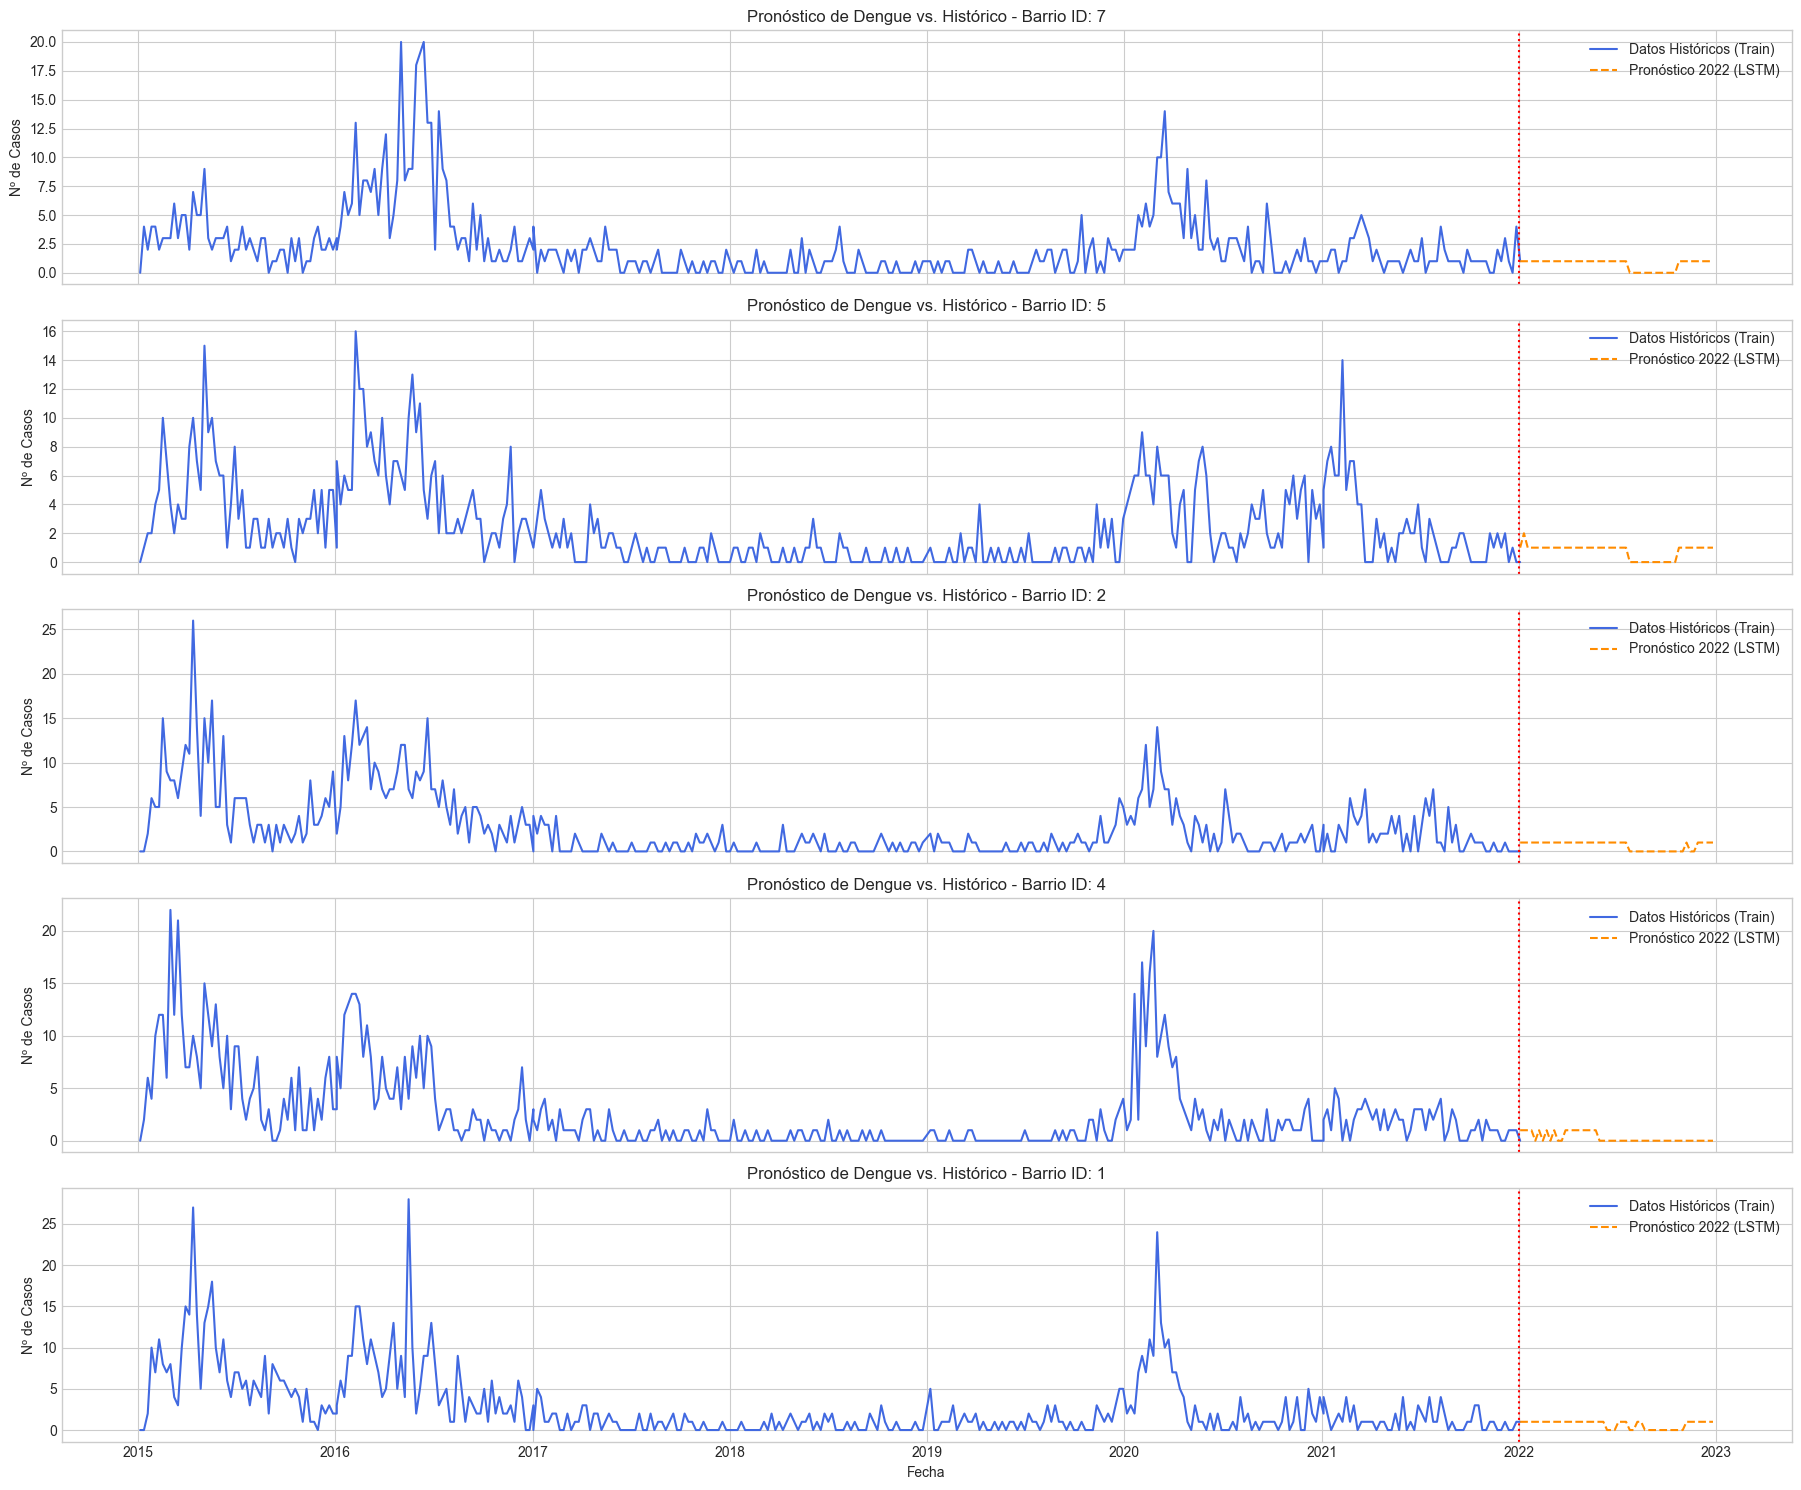

In [16]:
# --- Visualización de Resultados ---
print("\nVisualizando resultados de predicción vs datos históricos...")

# Cargar los datos originales sin escalar para la visualización
df_train_orig = pd.read_csv(TRAIN_PATH)
prediction_df = pd.read_csv(SUBMISSION_FILE_PATH)

# Extraer id_bar, anio, semana de la columna 'id'
temp_df = prediction_df['id'].str.split('_', expand=True)
prediction_df['id_bar'] = temp_df[0].astype(int)
prediction_df['anio'] = temp_df[1].astype(int)
prediction_df['semana'] = temp_df[2].astype(int)

# Crear columna de fecha para las predicciones
prediction_df['date'] = pd.to_datetime(prediction_df['anio'].astype(str) + ' ' + prediction_df['semana'].astype(str) + '-1', format='%Y %W-%w')


# Seleccionar una muestra de barrios para graficar
sample_bars_viz = np.random.choice(df_train_orig[ID_COL].unique(), size=5, replace=False)

fig, axes = plt.subplots(len(sample_bars_viz), 1, figsize=(18, 15), sharex=True)

for i, id_bar in enumerate(sample_bars_viz):
    # Datos históricos
    history_data = df_train_orig[df_train_orig[ID_COL] == id_bar]
    history_data['date'] = pd.to_datetime(history_data['anio'].astype(str) + ' ' + history_data['semana'].astype(str) + '-1', format='%Y %W-%w')
    
    # Datos predichos
    forecast_data = prediction_df[prediction_df['id_bar'] == id_bar]
    
    # Graficar
    axes[i].plot(history_data['date'], history_data[TARGET_COL], label='Datos Históricos (Train)', color='royalblue')
    axes[i].plot(forecast_data['date'], forecast_data[TARGET_COL], label='Pronóstico 2022 (LSTM)', color='darkorange', linestyle='--')
    axes[i].set_title(f"Pronóstico de Dengue vs. Histórico - Barrio ID: {id_bar}")
    axes[i].set_ylabel("Nº de Casos")
    axes[i].legend()
    axes[i].axvline(pd.to_datetime('2022-01-01'), color='red', linestyle=':', label='Inicio del Pronóstico')


plt.xlabel("Fecha")
plt.tight_layout()
plt.show()